# ANAC


In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, normalize

#### Seed

In [313]:
seed = 2024
np.random.seed(seed)

In [314]:
diet_csv = pd.read_csv("diet.csv").copy()
recipes_csv = pd.read_csv("recipes.csv").copy()
requests_csv = pd.read_csv("requests.csv").copy()
reviews_csv = pd.read_csv("reviews.csv").copy()

/var/folders/z0/24mzs0z565s6qpzztgbdrj780000gn/T/ipykernel_11064/3884275055.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_csv = pd.read_csv("reviews.csv").copy()


***Join Dataset***

In [315]:
# merge diet + request
request_with_diet = pd.merge(diet_csv, requests_csv, how="inner", on="AuthorId")
# merge diet + request + recipe
request_with_diet_and_recipe = pd.merge(recipes_csv, request_with_diet, how="inner", on="RecipeId")
# merge diet + request + recipe + review
df = pd.merge(reviews_csv, request_with_diet_and_recipe, how="inner", on=["AuthorId", "RecipeId"])
# merge whole df with own generated RecipeMatchesDiet

### Data Cleaning

#### Basics

In [316]:
# drop na diet column
df = df.dropna(subset=['Diet'])
# Rename AuthorId column
df.rename(columns= {
    "AuthorId" : "CustomerId", 
    "Time": "MaxTime"
}, inplace=True)

df["Like"] = df["Like"].astype("boolean")
# Change types into category and mapping values
df["Diet"] = df["Diet"].astype("category")

df["RecipeCategory"] = df["RecipeCategory"].astype("category")

mapping_cal = {1: 'Yes', 0.0: 'No'}
df['HighCalories'] = df['HighCalories'].map(mapping_cal).astype('category')

mapping_protein = {'Yes': 'Yes', 'Indifferent': 'Indifferent', 'No': 'No' }
df['HighProtein'] = df['HighProtein'].map(mapping_protein).astype('category')

mapping_cal = {1: 'Yes', 0.0: 'No'}
df['LowFat'] = df['LowFat'].map(mapping_cal).astype('category')

mapping_sugar = {'1': 'Yes', 'Indifferent': 'Indifferent', '0': 'No' }
df['LowSugar'] = df['LowSugar'].map(mapping_sugar).astype('category')

mapping_cal = {1: 'Yes', 0.0: 'No'}
df['HighFiber'] = df['HighFiber'].map(mapping_cal).astype('category')

# Remove NA rows and Rating column
df = df.drop("Rating", axis=1)


# One hot encoding for categorical variables
df = pd.get_dummies(df, columns=['Diet','RecipeCategory','HighCalories', 'LowFat', 'HighFiber', 'HighProtein', 'LowSugar'], drop_first=True)

df.rename(columns={
    'HighCalories_Yes': 'want_HighCalories',
    'LowFat_Yes':'want_LowFat',
    'HighFiber_Yes':'want_HighFiber',
    'HighProtein_Yes':'want_HighProtein',
}, inplace=True)

df["DifferenceRequestedAndTimeNeeded"] = df["MaxTime"] - (df["CookTime"] + df["PrepTime"])
df["TotalTimeNeeded"] = df["CookTime"] + df["PrepTime"]

In [317]:
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace(")", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("(", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("\"", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("\\", '')
df['RecipeIngredientParts'] = df['RecipeIngredientParts'].str.replace('^c', '', regex=True)

def check_keywords(ingredients):
    has_animal_product = any(any(keyword in ingredient.lower() for keyword in ["meat", "chicken", "lamb", "beef", "pork", "bacon", "fish", "sausage", "turkey", "milk", "butter", "egg", "cheese", "breast", "gelatin", "honey", "tuna", "steak", "salmon", "shrimps"]) for ingredient in ingredients)
    has_fish_or_meat = any(any(keyword in ingredient.lower() for keyword in ["meat", "chicken", "lamb", "beef", "pork", "bacon", "fish", "sausage", "turkey", "tuna", "steak", "salmon", 'shrimps']) for ingredient in ingredients)
    return has_animal_product, has_fish_or_meat

df[['has_animal_product', 'has_fish_meat']] = df['RecipeIngredientParts'].str.split(',').apply(check_keywords).apply(pd.Series)

df['for_Vegan'] = ~df['has_animal_product'] & ~df['has_fish_meat']
df['for_Vegetarian'] = (df['has_animal_product'] & ~df['has_fish_meat']) | (~df['has_animal_product'] & ~df['has_fish_meat'])
df['Correct_Diet'] = (~df['Diet_Vegetarian'] & ~df['Diet_Vegan']) | (df['Diet_Vegan'] & df['for_Vegan']) | (df['Diet_Vegetarian']  & df['for_Vegetarian'] )



***Split data***

In [318]:
# Split data into train and test set
train_set = df[df["TestSetId"].isna()]
test_set = df[df["TestSetId"].notnull()]

# Handling outliers

In [319]:
train_set = train_set[train_set["Calories"] < 300000]

### Missing values

In [320]:
train_set = train_set.dropna(subset=["Like"]).drop("TestSetId", axis=1)

In [321]:
# needs to be done after outlier removal
recipesServings_mean = train_set['RecipeServings'].mean()
#fill na rows with the mean
train_set.loc[:, 'RecipeServings'] = train_set['RecipeServings'].fillna(recipesServings_mean)
test_set.loc[:, 'RecipeServings'] = test_set['RecipeServings'].fillna(recipesServings_mean)

# Train model for each category


In [322]:
vegan_subset = train_set[train_set['Diet_Vegan'] == True]
vegetarian_subset = train_set[train_set['Diet_Vegetarian'] == True]
omnivore_subset = train_set[(train_set['Diet_Vegan'] == False) & (train_set['Diet_Vegetarian'] == False)]

## Vegan

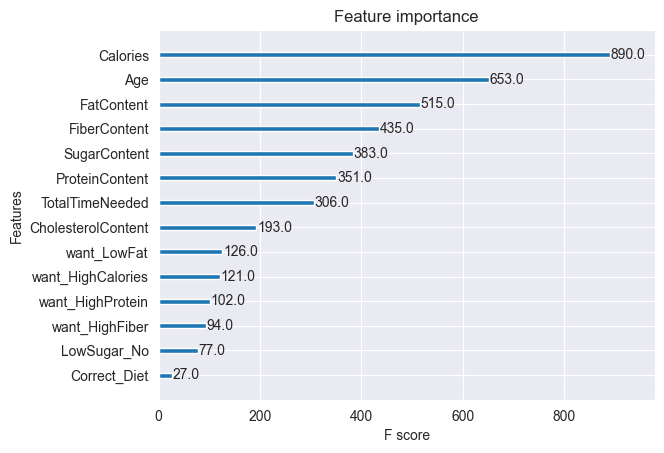

In [323]:
from imblearn.over_sampling import SMOTE

vegan_variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield','MaxTime','Diet_Vegetarian','Diet_Vegan', 'for_Vegetarian', 'for_Vegan', 'has_fish_meat', 'has_animal_product', 'PrepTime', 'CookTime', 'RecipeServings','RecipeCategory_Other', 'RecipeCategory_Bread', 'RecipeCategory_Breakfast', 'RecipeCategory_Lunch', 'RecipeCategory_One dish meal', 'RecipeCategory_Soup', 'DifferenceRequestedAndTimeNeeded','SaturatedFatContent', 'SodiumContent', 'CarbohydrateContent']
X = vegan_subset.drop(vegan_variables_to_drop, axis=1)
y = vegan_subset['Like']

X_train, X_test, y_train, y_test_vegan= \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3)

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=seed)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

model_beverages = XGBRegressor(n_estimators=100, random_state=seed)
model_beverages.fit(X_train, y_train)

# Plot feature importance
plot_importance(model_beverages)
plt.show()

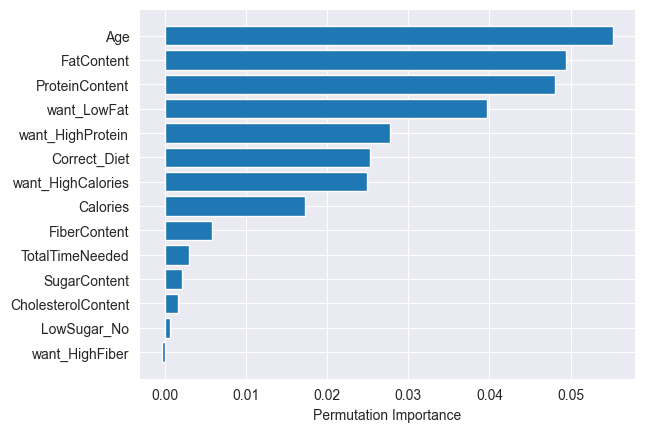

In [324]:
model_vegan = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model_vegan.fit(X_train, y_train)

# for the plot
perm_importance = permutation_importance(model_vegan, X_test, y_test_vegan)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

Test Balanced Accuracy: 0.7962959101398503


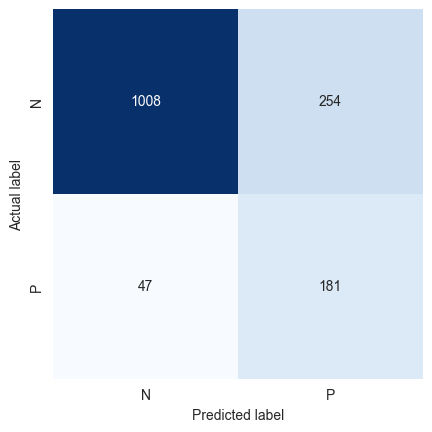

In [325]:
y_predicted = model_vegan.predict(X_test) > 0.5
mat = confusion_matrix(y_test_vegan, y_predicted)
labels = ['N', 'P']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
balanced_acc_vegan = balanced_accuracy_score(y_test_vegan, y_predicted)

print(f'Test Balanced Accuracy: {balanced_acc_vegan}')

TN_Vegan, FP_Vegan = mat[0, 0], mat[0, 1]
FN_Vegan, TP_Vegan = mat[1, 0], mat[1, 1]

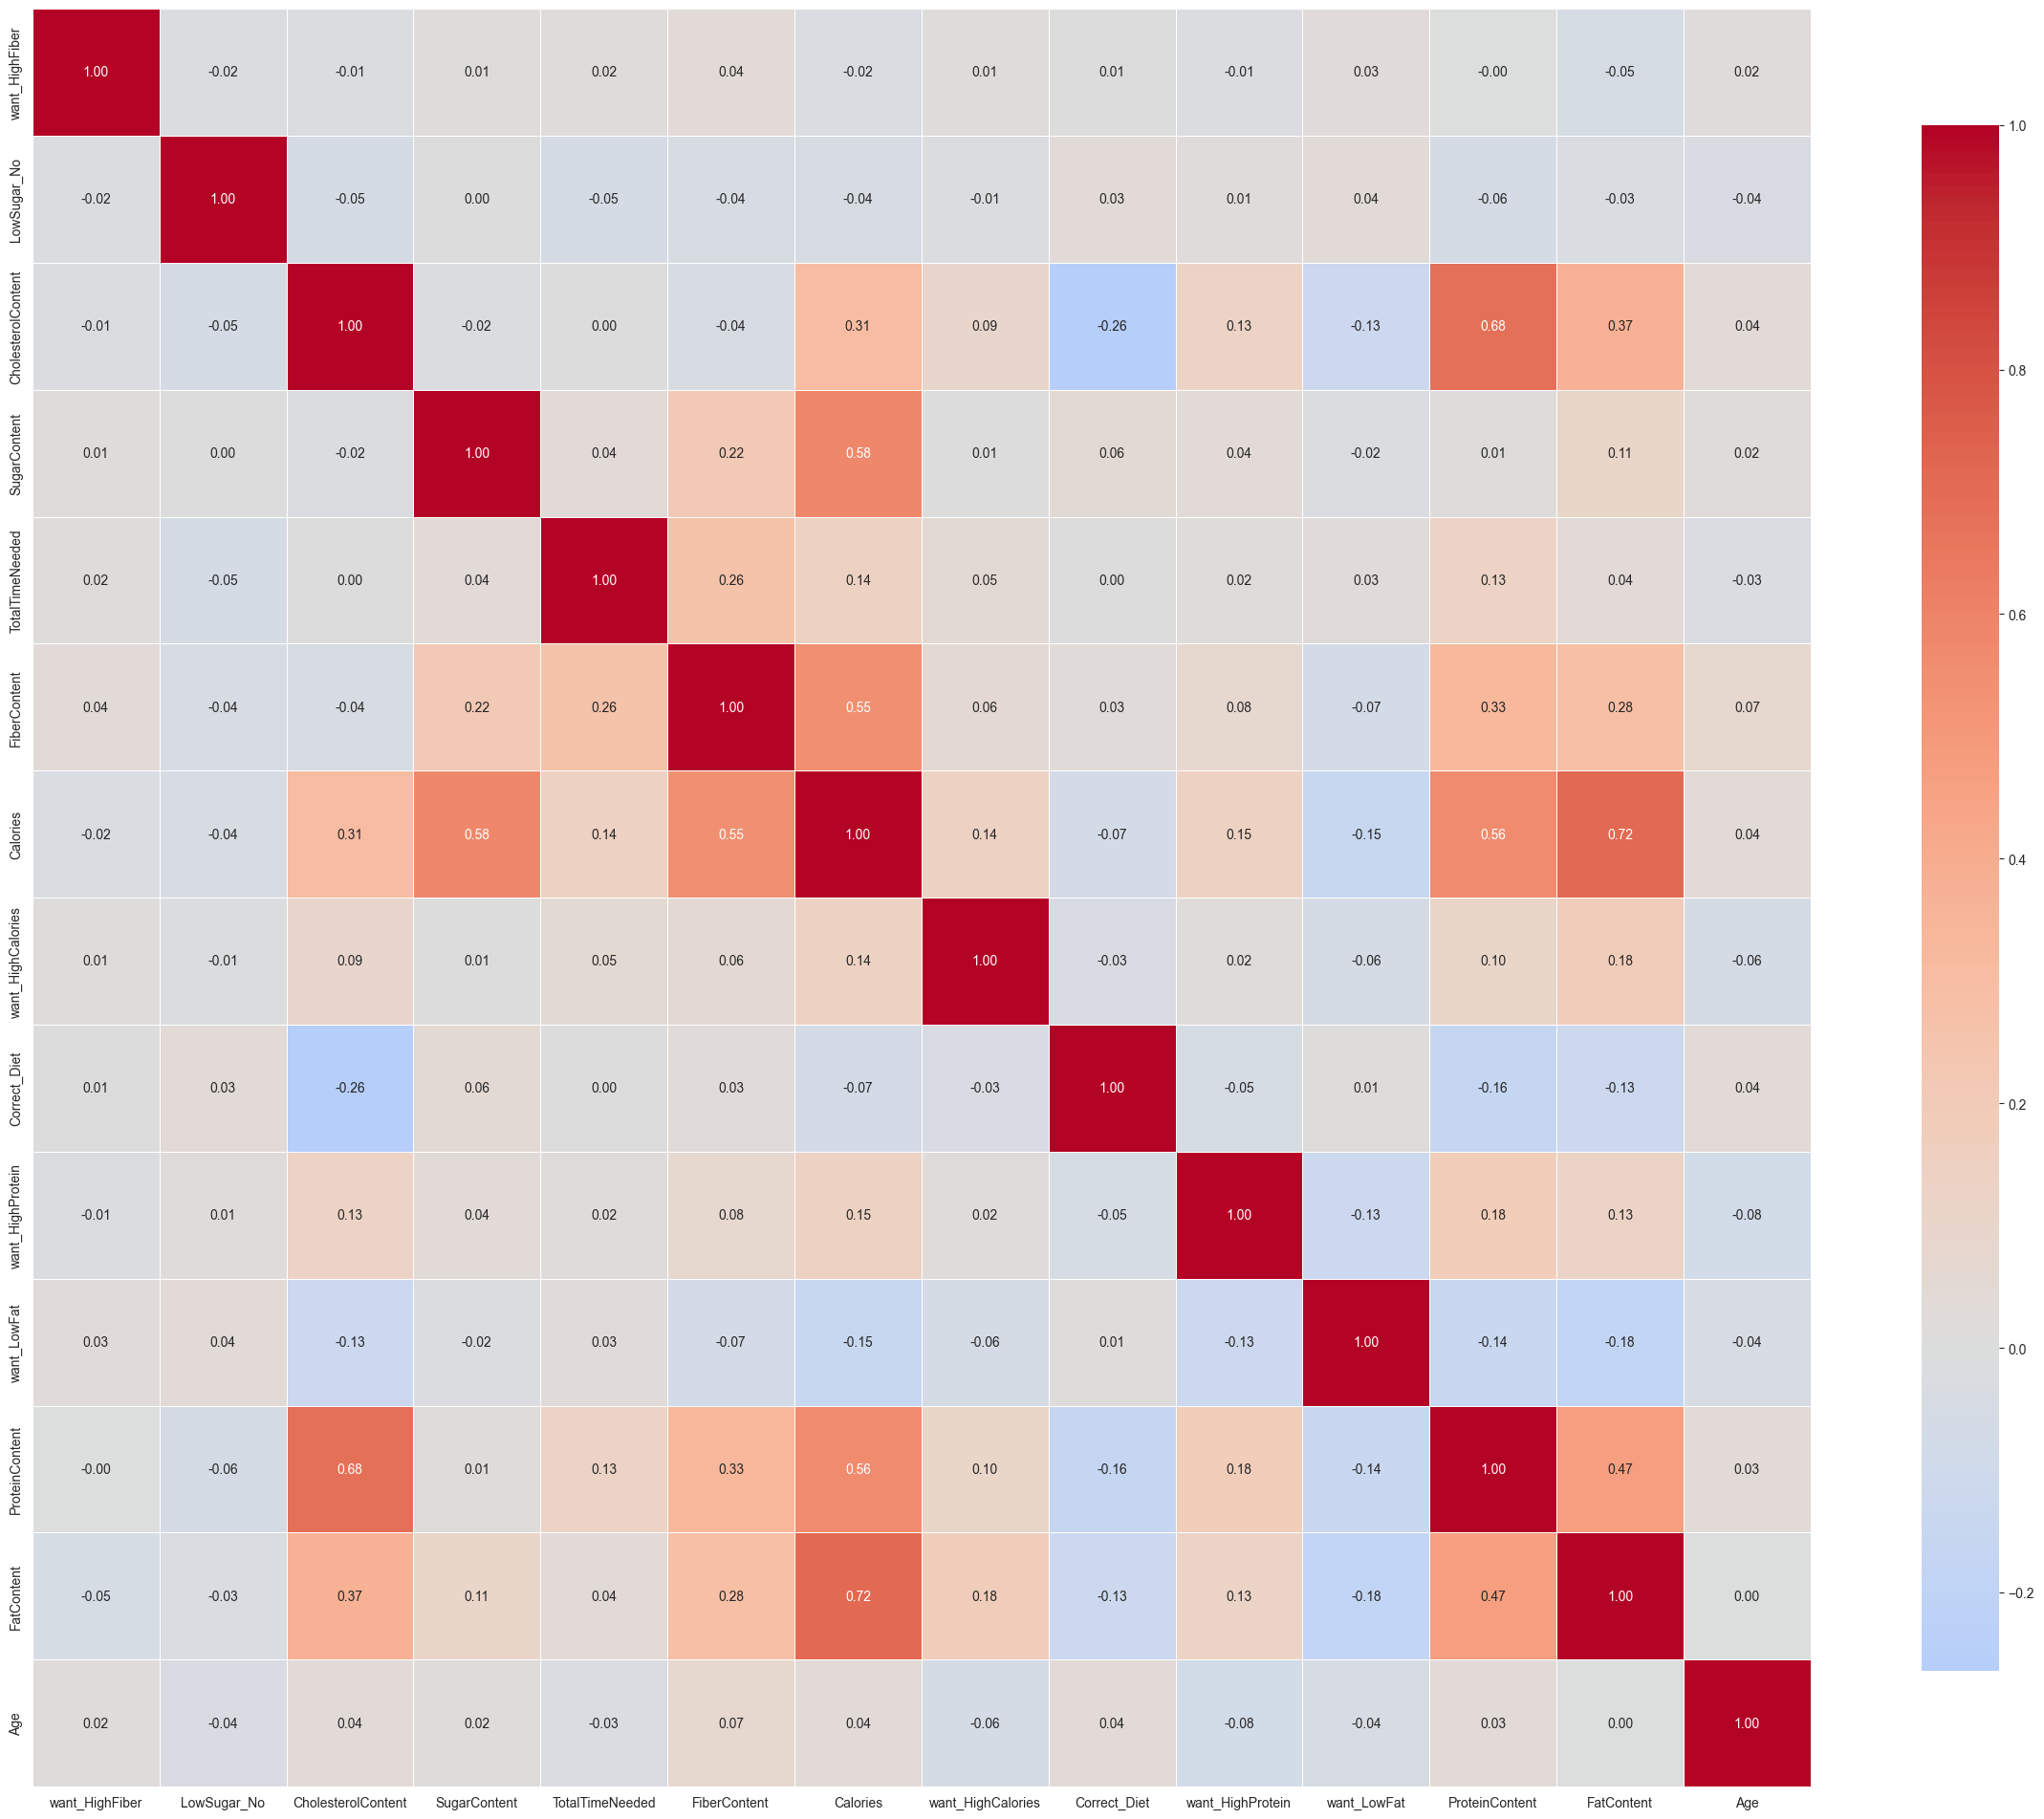

In [326]:
def correlation_heatmap(train):
    correlations = train.corr()
    
    fig, ax = plt.subplots(figsize=(30,30))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    
    plt.show();

correlation_heatmap(X_train[X.columns[sorted_idx]])

## Vegetarian

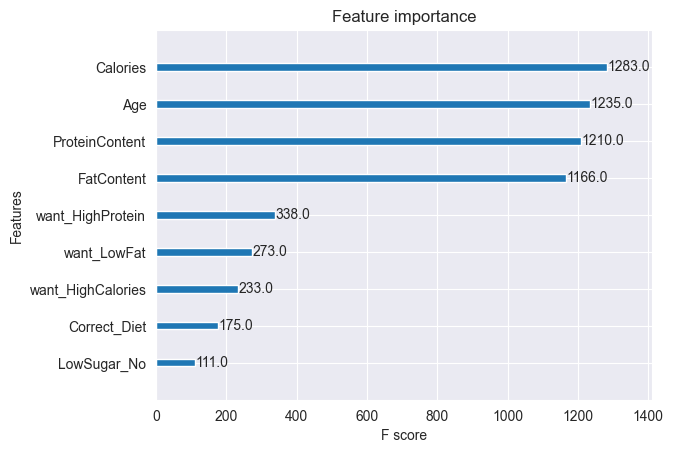

In [344]:
vegetarian_variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield','MaxTime','Diet_Vegetarian','Diet_Vegan', 'for_Vegetarian', 'for_Vegan', 'has_fish_meat', 'has_animal_product', 'PrepTime', 'CookTime','RecipeCategory_Other', 'RecipeCategory_Bread', 'RecipeCategory_Breakfast', 'RecipeCategory_Lunch', 'RecipeCategory_One dish meal', 'RecipeCategory_Soup', 'RecipeServings', 'SaturatedFatContent', 'DifferenceRequestedAndTimeNeeded', 'CarbohydrateContent', 'SodiumContent', 'CholesterolContent', 'TotalTimeNeeded', 'FiberContent', 'SugarContent', 'want_HighFiber']

X = vegetarian_subset.drop(vegetarian_variables_to_drop, axis=1)
y = vegetarian_subset['Like']

X_train, X_test, y_train, y_test_vegetarian= \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3)

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=seed)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

model_vegetarian = XGBRegressor(n_estimators=100, random_state=seed)
model_vegetarian.fit(X_train, y_train)


# Plot feature importance
plot_importance(model_vegetarian)
plt.show()

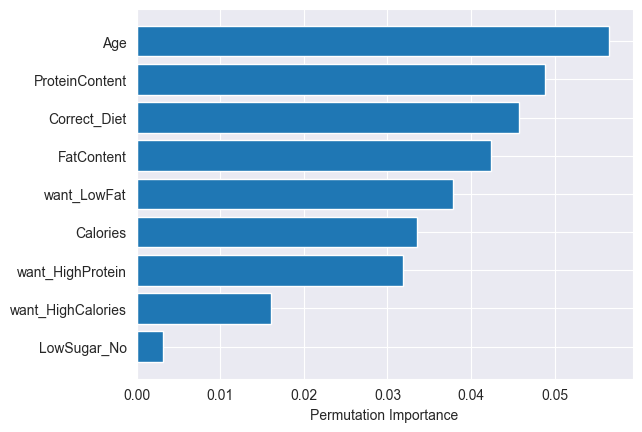

In [345]:
model_vegetarian = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model_vegetarian.fit(X_train, y_train)

perm_importance = permutation_importance(model_vegetarian, X_test, y_test_vegetarian)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

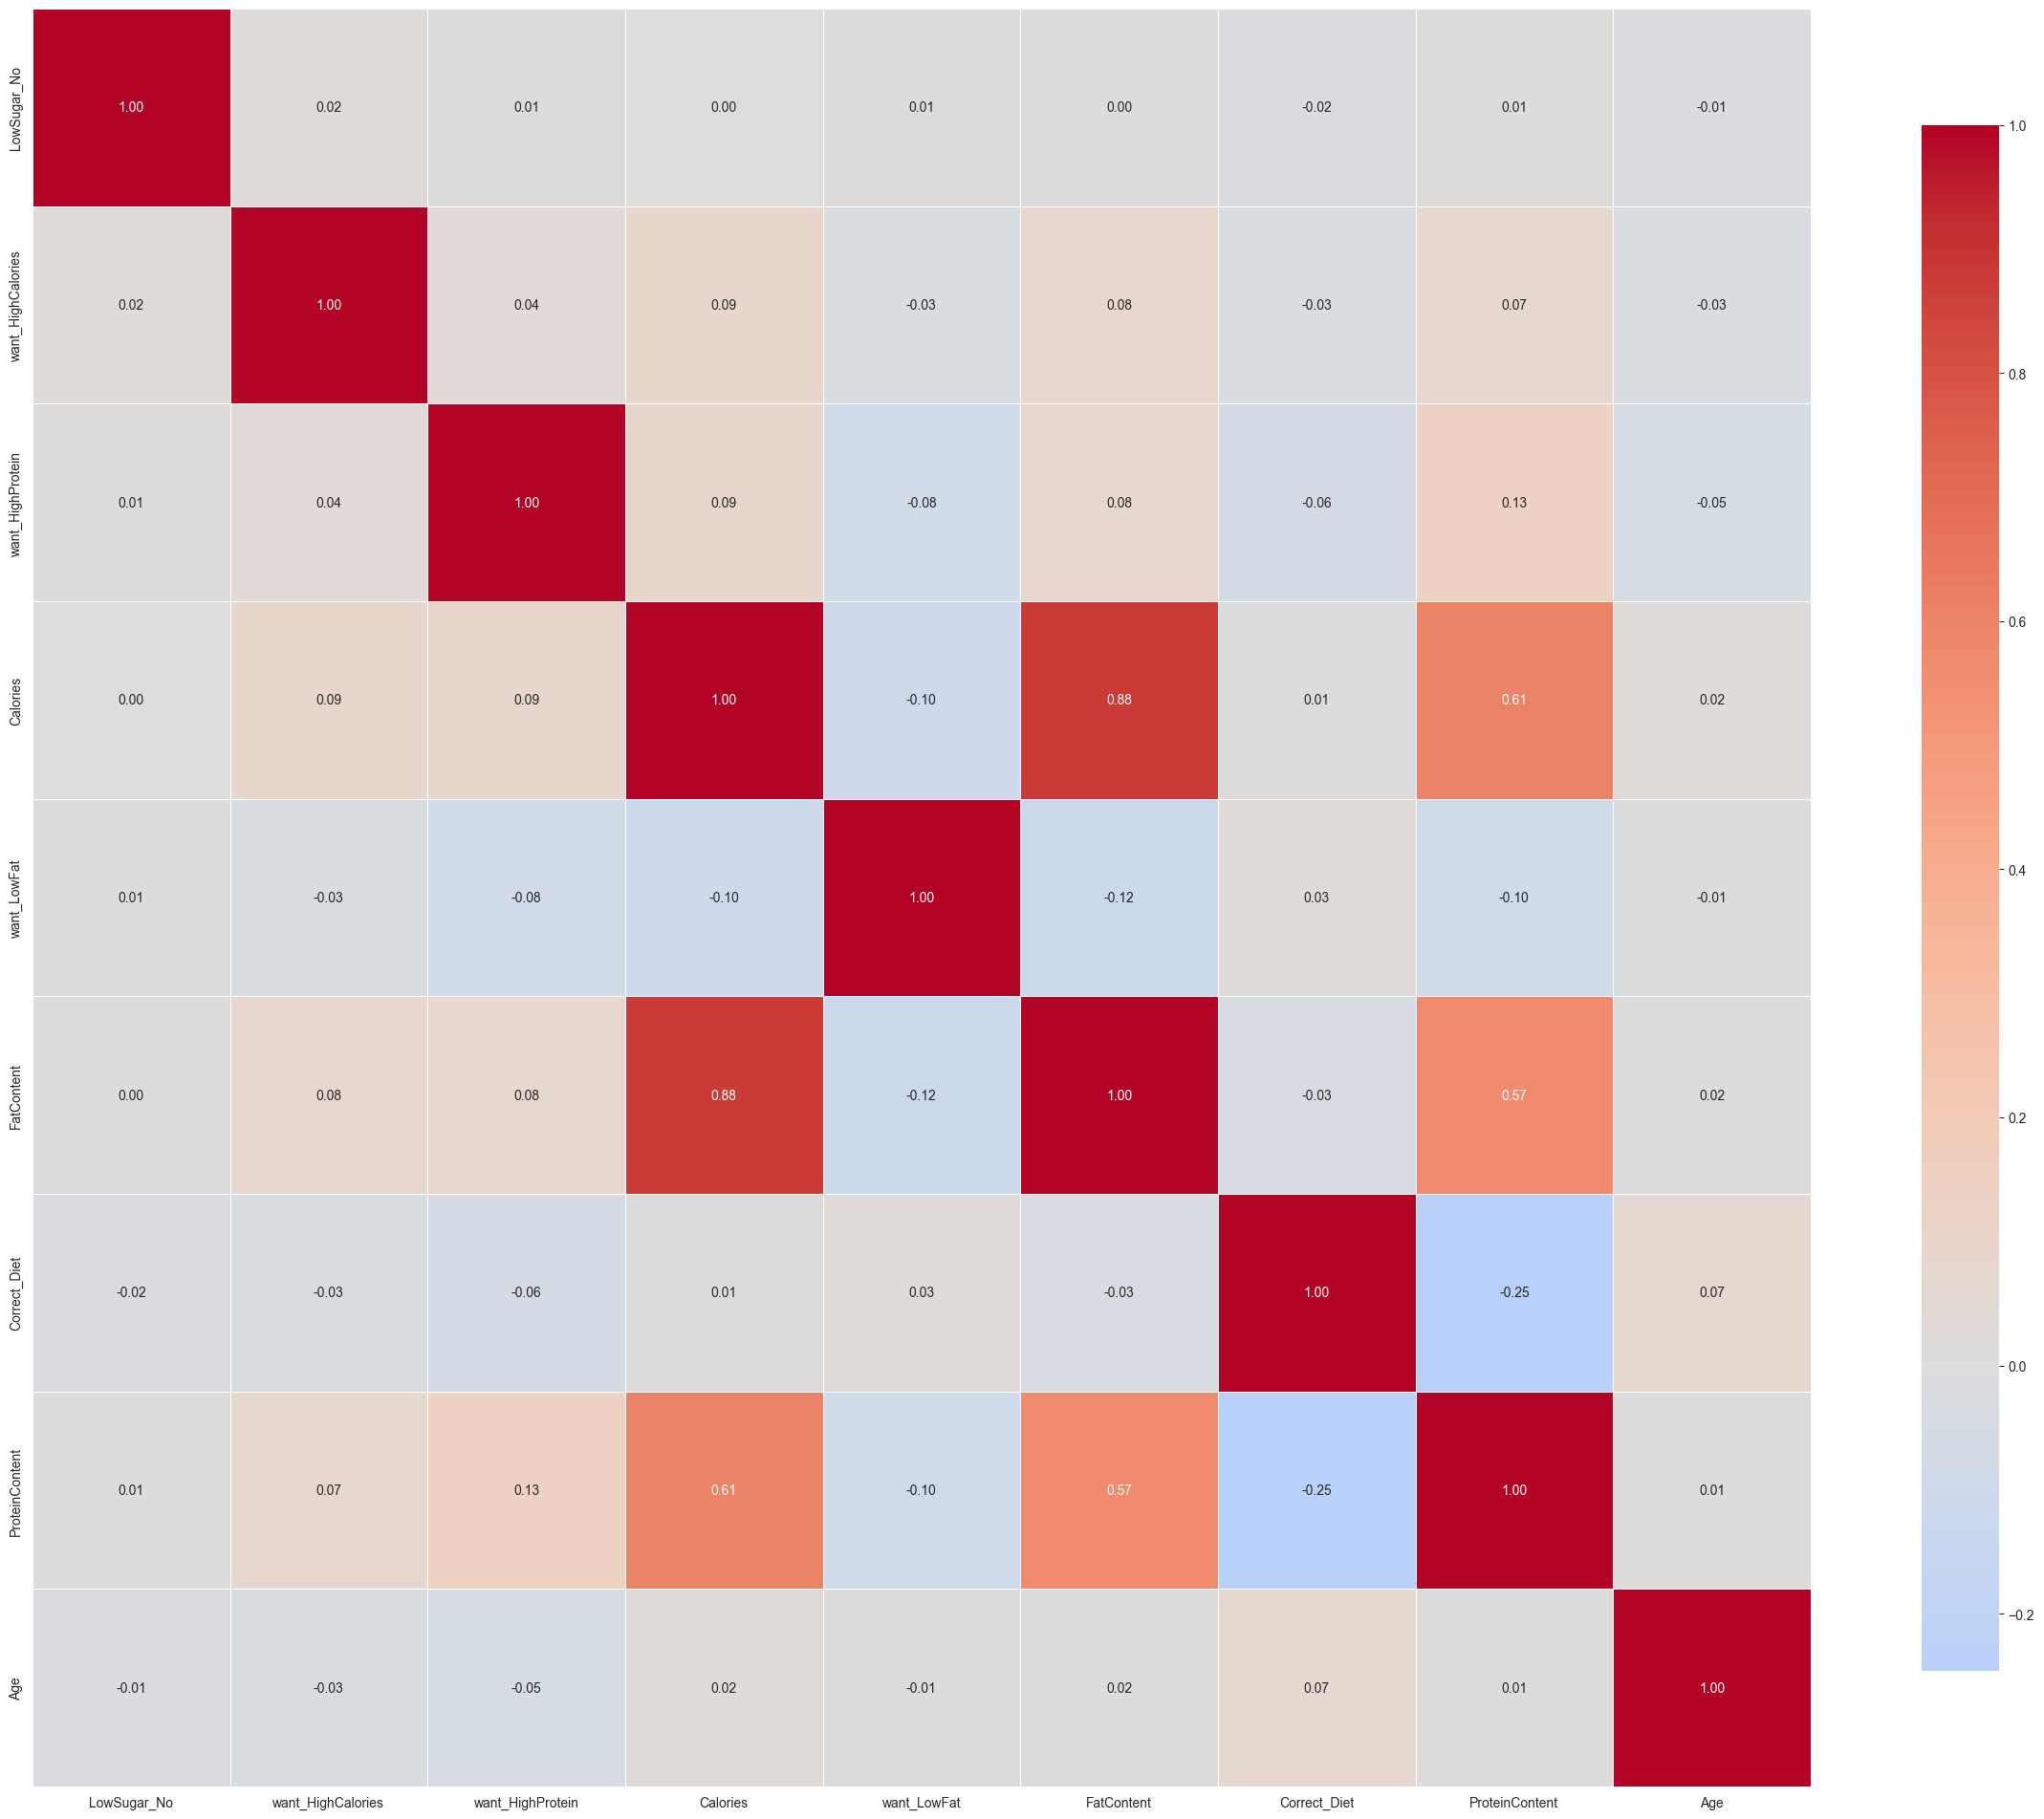

In [346]:
def correlation_heatmap(train):
    correlations = train.corr()
    
    fig, ax = plt.subplots(figsize=(30,30))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    
    plt.show();

correlation_heatmap(X_train[X.columns[sorted_idx]])

Test Balanced Accuracy: 0.8389262774227964


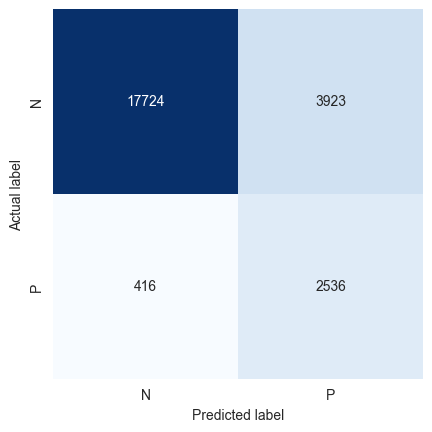

In [347]:
y_predicted = model_vegetarian.predict(X_test) > 0.5
mat = confusion_matrix(y_test_vegetarian, y_predicted)
labels = ['N', 'P']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
balanced_acc_vegetarian = balanced_accuracy_score(y_test_vegetarian, y_predicted)

print(f'Test Balanced Accuracy: {balanced_acc_vegetarian}')

TN_Vegetarian, FP_Vegetarian = mat[0, 0], mat[0, 1]
FN_Vegetarian, TP_Vegetarian = mat[1, 0], mat[1, 1]

## Omnivore

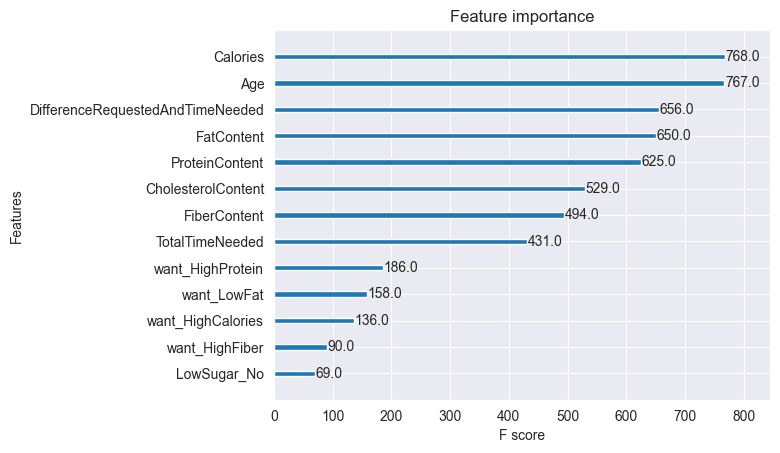

In [352]:
omnivore_variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield','MaxTime', 'Diet_Vegan','Diet_Vegetarian','for_Vegetarian', 'for_Vegan', 'has_fish_meat', 'has_animal_product', 'SugarContent', 'SaturatedFatContent', 'SodiumContent', 'CookTime', 'RecipeCategory_Other', 'RecipeCategory_Bread', 'RecipeCategory_Breakfast', 'RecipeCategory_Lunch', 'RecipeCategory_One dish meal', 'RecipeCategory_Soup', 'CarbohydrateContent', 'RecipeServings', 'Correct_Diet', 'PrepTime']

#['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield','MaxTime', 'Diet_Vegan','Diet_Vegetarian','for_Vegetarian', 'for_Vegan', 'RecipeCategory_Other', 'RecipeCategory_Bread', 'RecipeCategory_Breakfast', 'RecipeCategory_Lunch', 'RecipeCategory_One dish meal', 'RecipeCategory_Soup', 'CookTime', 'PrepTime', 'SodiumContent', 'RecipeServings', 'has_fish_meat', 'has_animal_product', 'Correct_Diet', 'SugarContent', 'SaturatedFatContent', 'CarbohydrateContent', 'CholesterolContent', 'want_HighFiber']

X = omnivore_subset.drop(omnivore_variables_to_drop, axis=1)
y = omnivore_subset['Like']

X_train, X_test, y_train, y_test_omnivore = \
train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3)

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=seed)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

model_omnivore = XGBRegressor(n_estimators=100, random_state=seed)
model_omnivore.fit(X_train, y_train)

# Plot feature importance
plot_importance(model_omnivore)
plt.show()

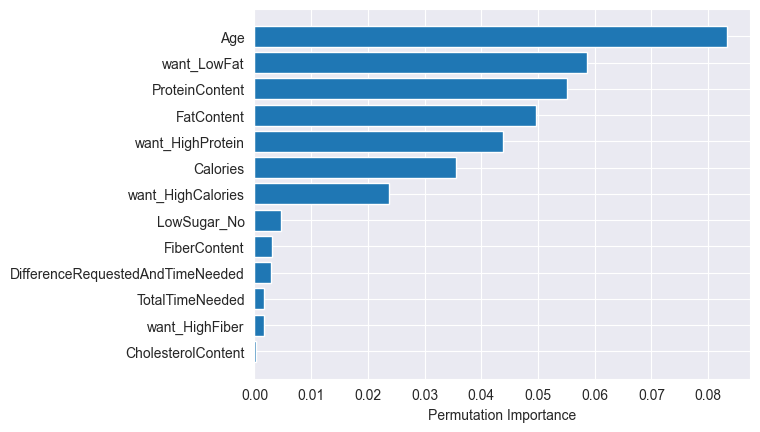

In [353]:
model_omnivore = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model_omnivore.fit(X_train, y_train)

perm_importance = permutation_importance(model_omnivore, X_test, y_test_omnivore)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

Test Balanced Accuracy: 0.8152476301525395


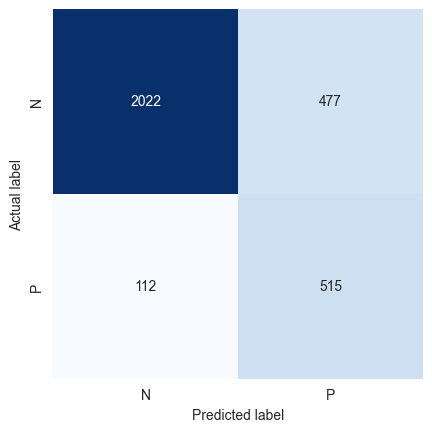

In [354]:
from sklearn.metrics import confusion_matrix
 
y_predicted = model_omnivore.predict(X_test) > 0.5
mat = confusion_matrix(y_test_omnivore, y_predicted)
labels = ['N', 'P']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
balanced_acc_omnivore = balanced_accuracy_score(y_test_omnivore, y_predicted)

print(f'Test Balanced Accuracy: {balanced_acc_omnivore}')

TN_Omnivore, FP_Omnivore = mat[0, 0], mat[0, 1]
FN_Omnivore, TP_Omnivore = mat[1, 0], mat[1, 1]

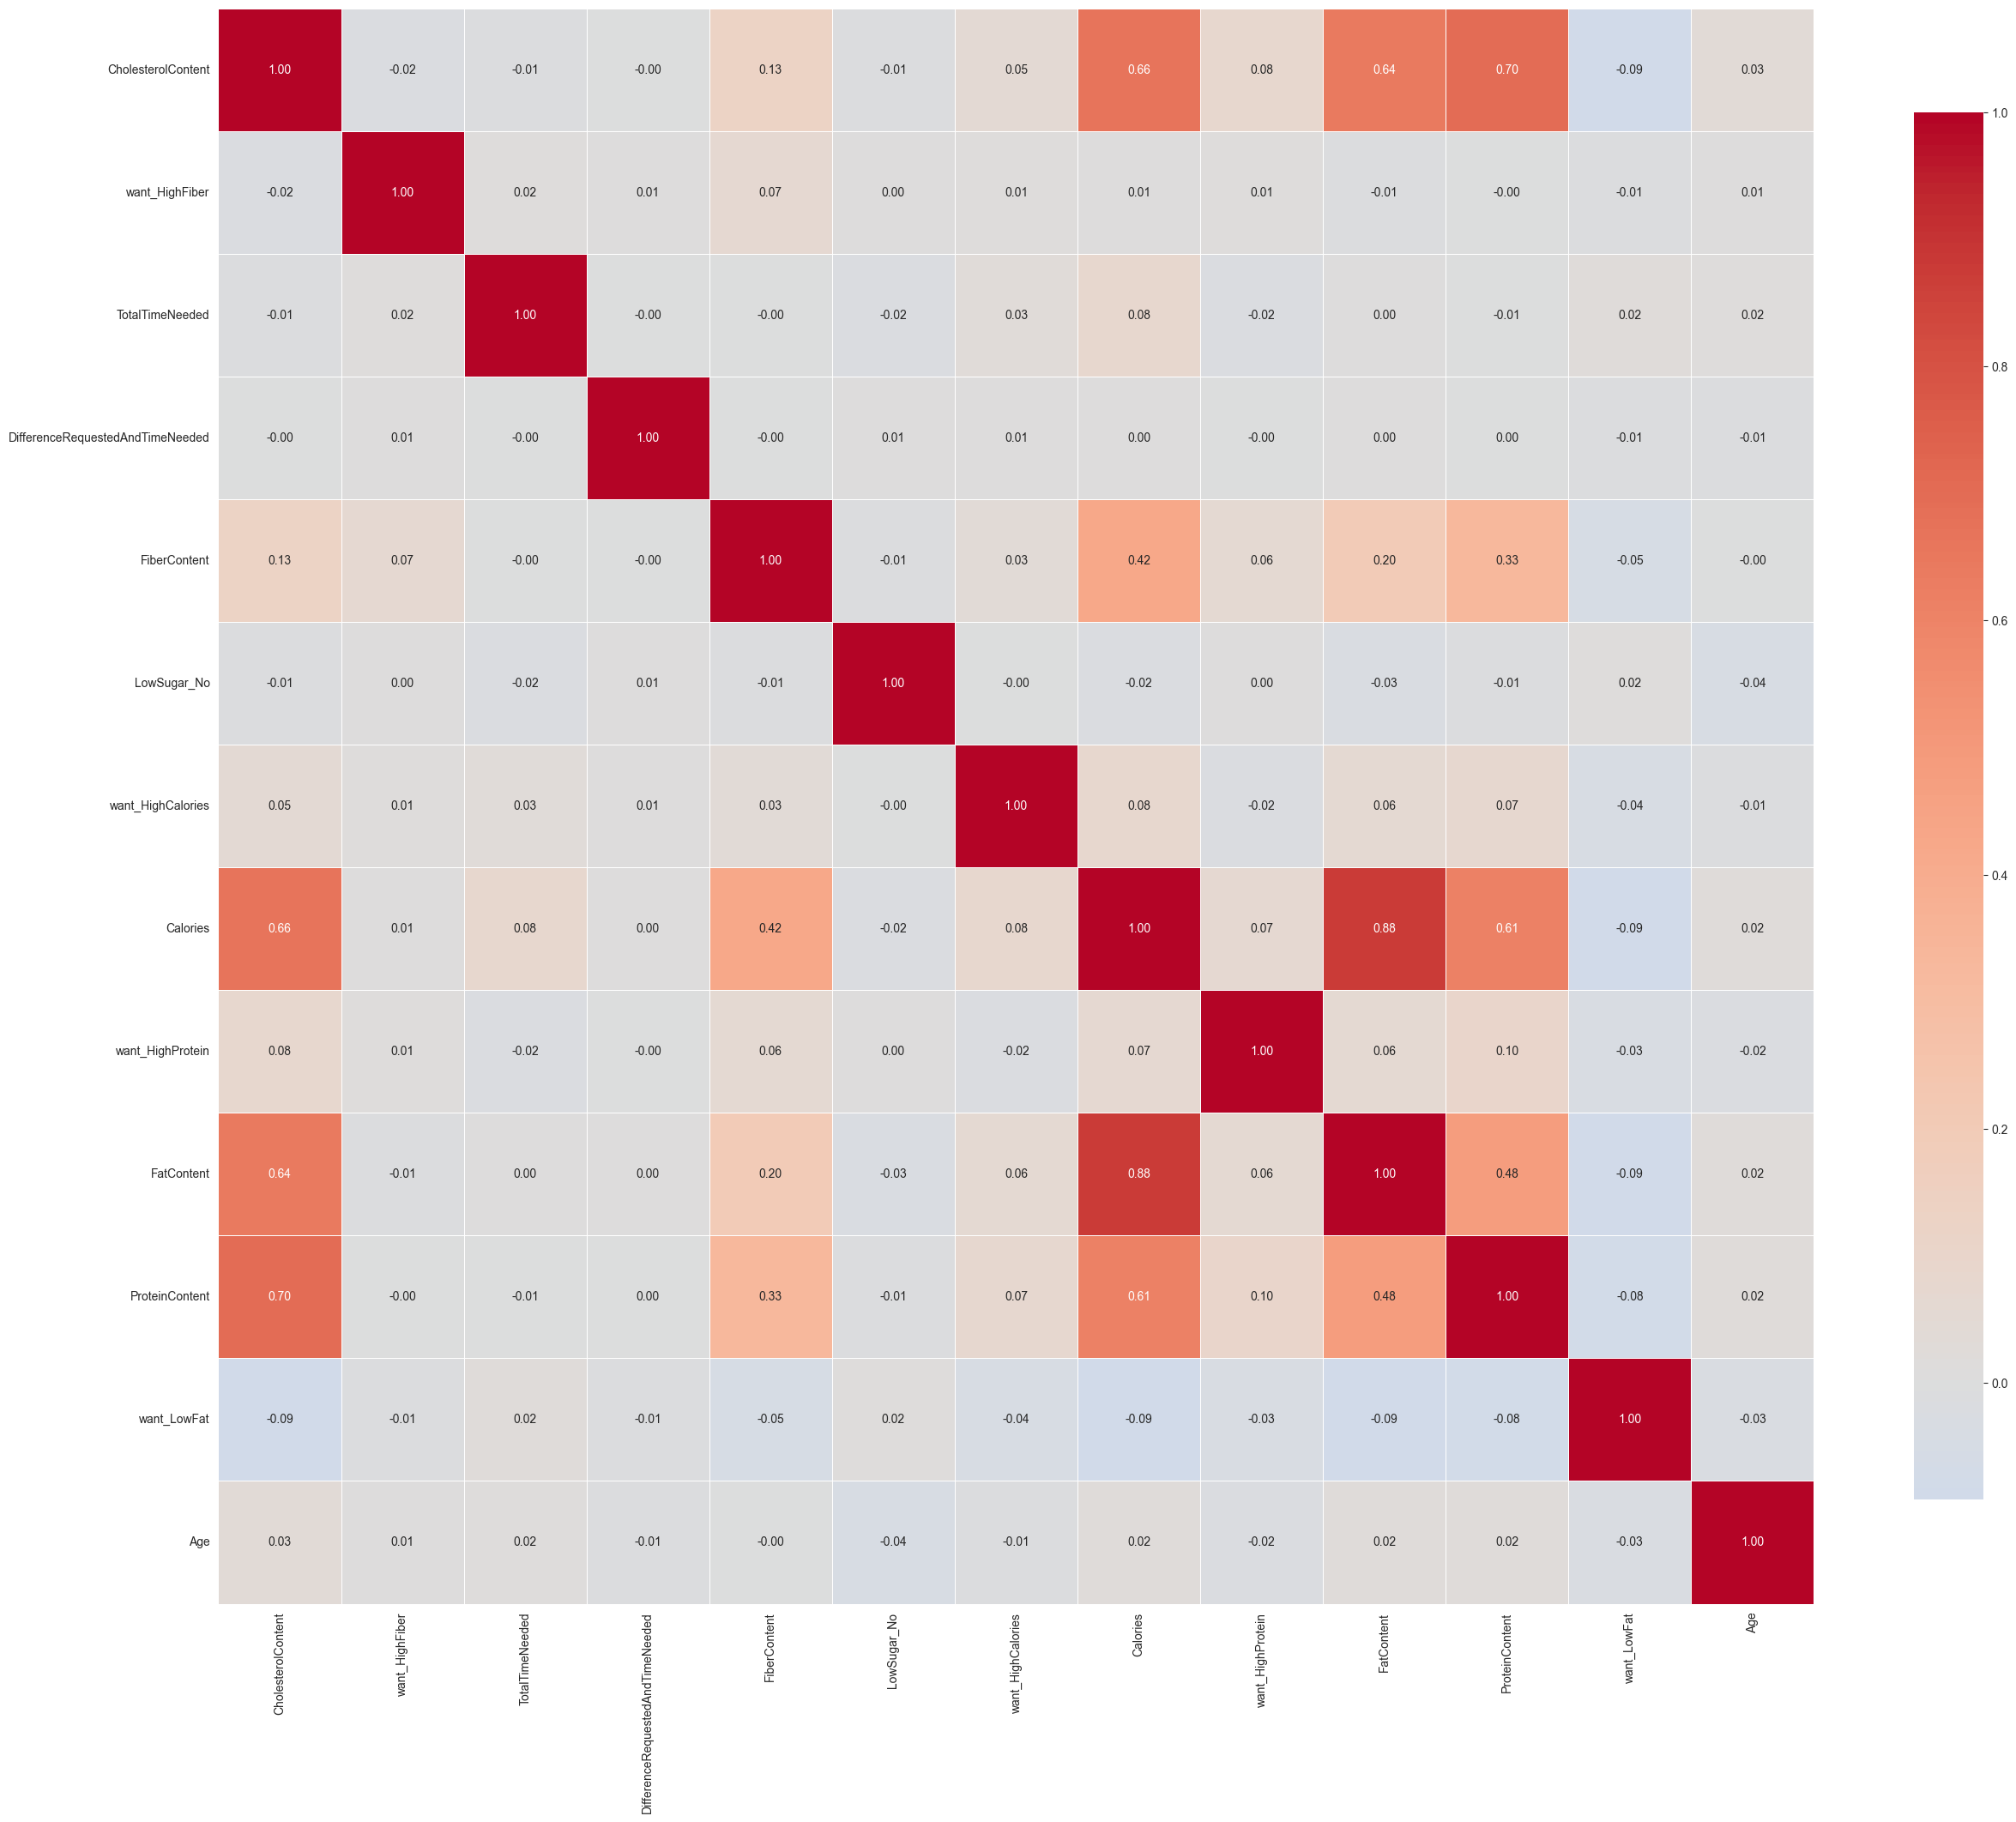

In [355]:
def correlation_heatmap(train):
    correlations = train.corr()
    
    fig, ax = plt.subplots(figsize=(30,30))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    
    plt.show();

correlation_heatmap(X_train[X.columns[sorted_idx]])

# Calculate balanced_accuracy all models

In [335]:
# Option one
overall_balanced_acc = (balanced_acc_vegan + balanced_acc_vegetarian + balanced_acc_omnivore) / 3

# Option two 
TP = TP_Vegan + TP_Vegetarian + TP_Omnivore
TN = TN_Vegan + TN_Vegetarian + TN_Omnivore 
FP = FP_Vegan + FP_Vegetarian + FP_Omnivore 
FN = FN_Vegan + FN_Vegetarian + FN_Omnivore 

TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

balanced_accuracy = (TPR + TNR) / 2
print("Overall Balanced Accuracy:", overall_balanced_acc)
print("Overall Balanced Accuracy:", balanced_accuracy)

Overall Balanced Accuracy: 0.8168232725717287
Overall Balanced Accuracy: 0.8328958913515405


In [339]:
subset_names = ['Vegan', 'Vegetarian', 'Omnivore']
y_test_combined = pd.concat([y_test_vegan, y_test_vegetarian, y_test_omnivore], axis=0)
# Print class distribution for each subset
for subset_name, y_test_subset in zip(subset_names, [y_test_vegan, y_test_vegetarian, y_test_omnivore]):
    print(f"Class Distribution for {subset_name}:\n{y_test_subset.value_counts()}\n")

# Print class distribution for the combined dataset
print("Class Distribution for Combined Dataset:\n", y_test_combined.value_counts())


Class Distribution for Vegan:
Like
False    1262
True      228
Name: count, dtype: Int64

Class Distribution for Vegetarian:
Like
False    21647
True      2952
Name: count, dtype: Int64

Class Distribution for Omnivore:
Like
False    2499
True      627
Name: count, dtype: Int64

Class Distribution for Combined Dataset:
 Like
False    25408
True      3807
Name: count, dtype: Int64


In [337]:
# Split test_set into subsets 
test_vegan = test_set[test_set['Diet_Vegan'] == True]
test_vegetarian = test_set[test_set['Diet_Vegetarian'] == True]
test_omnivore = test_set[(test_set['Diet_Vegan'] == False) & (test_set['Diet_Vegetarian'] == False)]

# drop variables
test_vegan = test_vegan.drop(vegan_variables_to_drop, axis=1)
test_vegetarian = test_vegetarian.drop(vegetarian_variables_to_drop, axis=1)
test_omnivore = test_omnivore.drop(omnivore_variables_to_drop, axis=1)


# Make predictions on each subset using the corresponding model
test_vegan['prediction'] = model_vegan.predict(test_vegan.drop(['TestSetId'], axis=1))
test_vegetarian['prediction'] = model_vegetarian.predict(test_vegetarian.drop(['TestSetId'], axis=1))
test_omnivore['prediction'] = model_omnivore.predict(test_omnivore.drop(['TestSetId'], axis=1))


test_output = pd.concat([
    pd.DataFrame({"id": test_vegan["TestSetId"].astype(int), "prediction": test_vegan["prediction"].astype(int)}),
    pd.DataFrame({"id": test_vegetarian["TestSetId"].astype(int), "prediction": test_vegetarian["prediction"].astype(int)}),
    pd.DataFrame({"id": test_omnivore["TestSetId"].astype(int), "prediction": test_omnivore["prediction"].astype(int)})
], ignore_index=True)

test_output = test_output.sort_values(by="id").reset_index(drop=True)
test_output.to_csv("predictions_LetsSeePaulAllens'BAC_test_diet.csv", index=False)

In [338]:
test_output1 = pd.read_csv("predictions_LetsSeePaulAllens'BAC_4.csv").copy()
test_output2 = pd.read_csv("predictions_LetsSeePaulAllens'BAC_test_diet.csv").copy()

merged_predictions = pd.merge(test_output1, test_output2, on="id", suffixes=('_1', '_2'))

merged_predictions['prediction_differs'] = merged_predictions['prediction_1'] != merged_predictions['prediction_2']

# Filter rows where predictions differ
differing_predictions = merged_predictions[merged_predictions['prediction_differs']]
differing_predictions.to_csv('differing_predictions_diet.csv', index=False)

percentage_difference = (len(differing_predictions) / len(merged_predictions)) * 100

print(f"Percentage of differing predictions: {percentage_difference}%")
print("Rows where predictions differ:")
print(differing_predictions[['id', 'prediction_1', 'prediction_2']])


Percentage of differing predictions: 10.031765310412482%
Rows where predictions differ:
          id  prediction_1  prediction_2
1          2             1             0
5          6             1             0
19        20             1             0
22        23             1             0
26        27             1             0
...      ...           ...           ...
42747  42748             1             0
42750  42751             0             1
42753  42754             0             1
42771  42772             0             1
42790  42791             1             0

[4295 rows x 3 columns]
